In [1]:
%matplotlib inline
from math import pi, sin, cos
import numpy as np
import openmc

In [2]:
fuel = openmc.Material(name='uo2')
fuel.add_element('U',1.0, enrichment=19.75)
fuel.add_element('O',2.0)
fuel.set_density=10.5
fuel.temperature = 1200

clad_in = openmc.Material(name='graphite')
clad_in.add_element('C',1.0)
clad_in.temperature = 1200

clad_out = openmc.Material(name='SiC')
clad_out.add_element('C',1.0)
clad_out.add_element('Si',1.0)
clad_out.temperature = 900

coolant = openmc.Material(name='LiOH+NaOH')
coolant.add_element('Li',1.0, enrichment=99.995, enrichment_target='Li7',enrichment_type='ao')
coolant.add_element('H',1.0)
coolant.add_element('O',1.0)
coolant.add_element('Na',1.0)
coolant.set_density('g/cm3', 1.670)
coolant.temperature = 900 

moderator = openmc.Material(name='graphite')
moderator.add_element('C',1.0)
moderator.temperature = 900 

materials = openmc.Materials([fuel,clad_in,clad_out,coolant,moderator])
materials.export_to_xml()

/home/m240600/.conda/envs/openmc-env/lib/python3.11/site-packages/openmc/material.py:740: UserWarning: A uranium enrichment of 19.75 was given for Material ID="1". OpenMC assumes the U234/U235 mass ratio is constant at 0.008, which is only valid at low enrichments. Consider setting the isotopic composition manually for enrichments over 5%.
  warnings.warn(msg)


In [3]:
r_fuel   = 0.35
r_clad_1 = 0.5
r_clad_2 = 0.6

r_pt_in  = 7.5 #inner radius of the graphite pressure tube
r_pt_out = 8.5 #outer radius of the graphite pressure tube

lattice_pitch = 18

ring_radii = np.array([0.0, 2.1, 4.2, 6.2])

In [4]:
radial_surf = [openmc.ZCylinder(r=r) for r in
               (ring_radii[:-1] + ring_radii[1:])/2]

coolant_cells = []
for i in range(ring_radii.size):
    if i == 0:
        coolant_region = -radial_surf[i]
    elif i == ring_radii.size - 1:
        coolant_region = +radial_surf[i-1]
    else:
        coolant_region = +radial_surf[i-1] & -radial_surf[i]

    coolant_cells.append(openmc.Cell(fill=coolant, region=coolant_region))

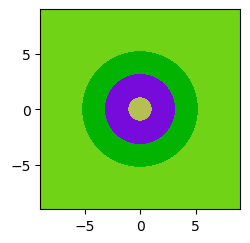

In [5]:
plot_args = {'width':(lattice_pitch,lattice_pitch)}
bundle_universe = openmc.Universe(cells=coolant_cells)
bundle_universe.plot(**plot_args)

In [6]:
surf_fuel = openmc.model.RightCircularCylinder((0,0,-81.6725),163.345,r_fuel)

surf_clad_1 = openmc.model.RightCircularCylinder((0,0,-81.6725),163.345,r_clad_1)
surf_clad_2 = openmc.model.RightCircularCylinder((0,0,-81.6725),163.345,r_clad_2)

surf_pt_1 = openmc.model.RightCircularCylinder((0,0,-81.6725),163.345,r_pt_in)
surf_pt_2 = openmc.model.RightCircularCylinder((0,0,-81.6725),163.345,r_pt_out)
                               
fuel_cell = openmc.Cell(fill=fuel, region=-surf_fuel)

clad_cell_1 = openmc.Cell(fill=clad_in, region=+surf_fuel & -surf_clad_1)
clad_cell_2 = openmc.Cell(fill=clad_out, region=+surf_clad_1 & -surf_clad_2)

coolant_cell = openmc.Cell(fill=coolant, region= -surf_pt_1 & +surf_clad_2)

pin_universe = openmc.Universe(cells=(fuel_cell,clad_cell_1,clad_cell_2,coolant_cell))

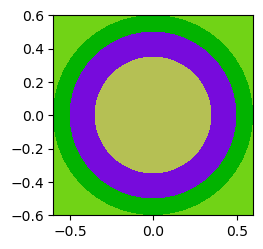

In [7]:
pin_universe.plot(**{'width':(2*r_clad_2,2*r_clad_2)})

In [8]:
num_pins = [1, 6, 12, 18]
angles = [0, 0, 15, 0]

for i, (r, n, a) in enumerate(zip(ring_radii, num_pins, angles)):
    for j in range(n):
        theta = (a + j/n*360)*pi/180.
        x = r*cos(theta)
        y = r*sin(theta)

        pin_boundary = openmc.model.RightCircularCylinder((x,y,-81.6725),163.345,r_clad_2)
        coolant_cells[i].region &= +pin_boundary

        pin = openmc.Cell(fill=pin_universe, region=-pin_boundary)
        pin.translation = (x, y, 0)
        pin.id = (i + 1)*100 + j
        bundle_universe.add_cell(pin)

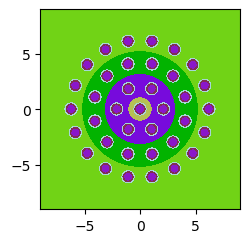

In [9]:
bundle_universe.plot(**plot_args)

In [10]:
pt_inner = openmc.model.RightCircularCylinder((0,0,-81.6725),163.345,r_pt_in)
pt_outer = openmc.model.RightCircularCylinder([0,0,-81.6725],163.345,r_pt_out)
lattice_boundary = openmc.model.RectangularParallelepiped(-lattice_pitch/2,lattice_pitch/2,-lattice_pitch/2,lattice_pitch/2,-81.6725,81.6725,boundary_type='reflective')

pt=openmc.Cell(fill=clad_in, region= +pt_inner & -pt_outer)
moderator_cell=openmc.Cell(fill=moderator, region=-lattice_boundary & +pt_outer)

bundle = openmc.Cell(fill=bundle_universe, region=-pt_inner)
lattice_universe = openmc.Universe(cells=[bundle,pt,moderator_cell])

In [11]:
external_moderator=openmc.Cell(fill=moderator, region=-lattice_boundary)

In [12]:
geometry = openmc.Geometry(lattice_universe)
geometry.export_to_xml()

materials=openmc.Materials(geometry.get_all_materials().values())
materials.export_to_xml()

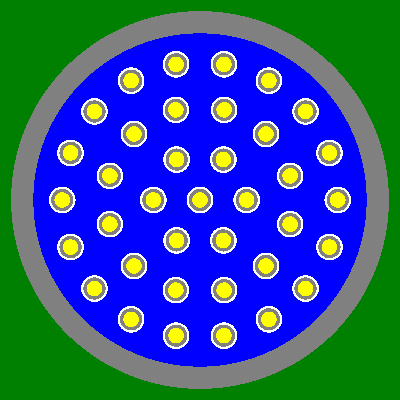

In [13]:
plot = openmc.Plot.from_geometry(geometry)
plot.color_by = 'material'
plot.colors = {
    fuel: 'yellow',
    clad_in: 'grey',
    clad_out: 'white',
    coolant: 'blue',
    moderator: 'green',
}
plot.to_ipython_image()

In [14]:
settings = openmc.Settings()
settings.particles = 1000
settings.batches = 50
settings.inactive = 10
settings.source = openmc.Source(space=openmc.stats.Point())
settings.export_to_xml()

In [15]:
fuel_tally = openmc.Tally()
fuel_tally.filters = [openmc.DistribcellFilter(fuel_cell)]

In [16]:
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################